In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
from Trajectory import Trajectory
sys.path.insert(1,'../code/data_utils/')
from ConfigDataset import ConfigDataset
from HiCDataset import HiCDataset
from HiCMap import HiCMap
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [6]:
config_fp = '../data/processed_data.hdf5'
num_bins = 64
resolution = 20_000
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp='../data/squares.pt'

mcool_fp = '../data/outside/GM12878_hg19.mcool'
interp_nans = False
balance_hic = True
adaptive_coarsegraining = False
adaptive_coarsegraining_cutoff = 3
adaptive_coarsegraining_max_levels = 8

save_dir = './GM_vs_IMR2/'

# Gen configs
config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
aligned_config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/aligned/'
cond_scale = 5.0
rescaled_phi = 8.0
milestone = 120
resolution = 20_000

gm_hic_fp = '../data/outside/GM12878_hg19.mcool'
imr_hic_fp = '../data/outside/IMR90_hg19.mcool'

# For loading dcd files
topology_file = aligned_config_directory+'topology.psf'

regions = { # chrom:region_idxs
    '1':[10040],
    '2':[43,50,3380,3993,6284],
    '3':[3452],
    '4':[9117],
    '5':[1618,1705,4631],
    '6':[290,6358],
    '7':[953,1303,1691,2728,4227,5540],
    '8': [515, 740, 1852, 2131, 2993, 3668, 3693, 4600],
    '9': [1028, 1053, 1873, 1895],
    '10': [1489, 2189, 2514],
    '11': [2687],
    '12': [611, 3019],
    '13': [1174],
    '16': [1176],
    '17': [1835],
    '18': [1231],
    '19': [269, 282, 2459],
    '21': [693, 705]
}

In [7]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')

In [4]:
gm_hic = HiCDataset(gm_hic_fp)
imr_hic = HiCDataset(imr_hic_fp)

In [5]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]

In [6]:
def get_gen_coords(chrom,region_idx,cond_scale=cond_scale,rescaled_phi=rescaled_phi,milestone=milestone):
    filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    gen_configs = Coordinates(gen_configs*100) # * 100 to convert to nm
    return gen_configs.float_().cpu_()

In [7]:
def get_tan_coords(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    # * 100 to convert to nm
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]*100).float_().cpu_(), start_idx

RMSD hist

In [8]:
def rmsd_hist(reference,samples,*args,**kwargs):

    backup = samples
    
    samples = backup.clone().trajectory
    reference = reference[0].clone().trajectory
    reference.mdtraj.center_coordinates()
    
    samples.superpose(reference)
    #rmsds = (samples.values.double() - reference.values.double().expand_as(samples.values)).square().mean().sqrt()
    rmsds0 = samples.rmsd(reference)

    samples = backup.clone().trajectory
    reference = reference[0].clone().trajectory
    reference.mdtraj.center_coordinates()
    samples.mdtraj.xyz[...,-1]*= -1
    
    samples.superpose(reference)
    rmsds = torch.min(
        rmsds0,
        samples.rmsd(reference)
        #(samples.values.double() - reference.values.double().expand_as(samples.values)).square().mean()
    )

    
    #rmsds = samples.rmsd(reference)

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.hist(rmsds.cpu().numpy().flatten(),density=True,*args,**kwargs)
    ax.hist(rmsds0.cpu().numpy().flatten(),density=True,*args,**kwargs)

    return fig, ax, rmsds0


In [9]:
chrom = '1'
region_idx = 395
tan_coords,_ = get_tan_coords(chrom,region_idx)
gen_coords = get_gen_coords(chrom,region_idx)

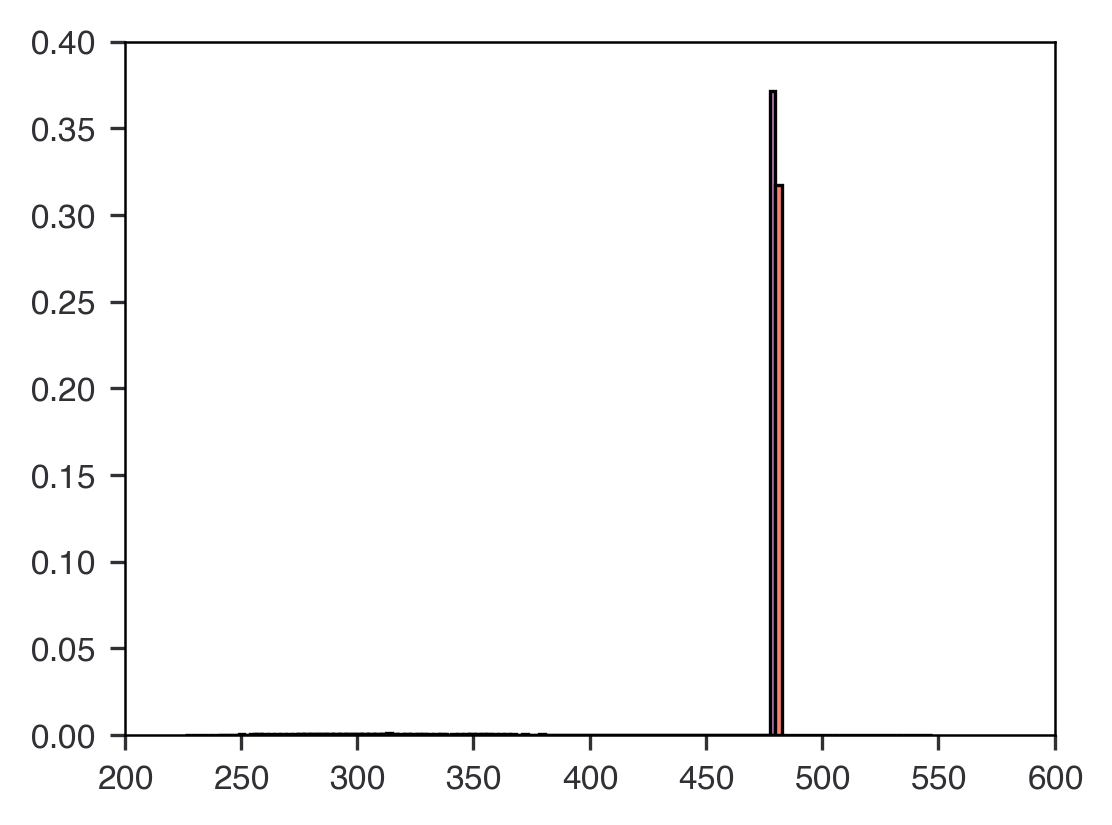

In [10]:
*_,rmsds=rmsd_hist(tan_coords[2],gen_coords,bins=100)

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot: xlabel='Genomic Index', ylabel='Genomic Index'>,
 <matplotlib.colorbar.Colorbar at 0x7f4db689a340>)

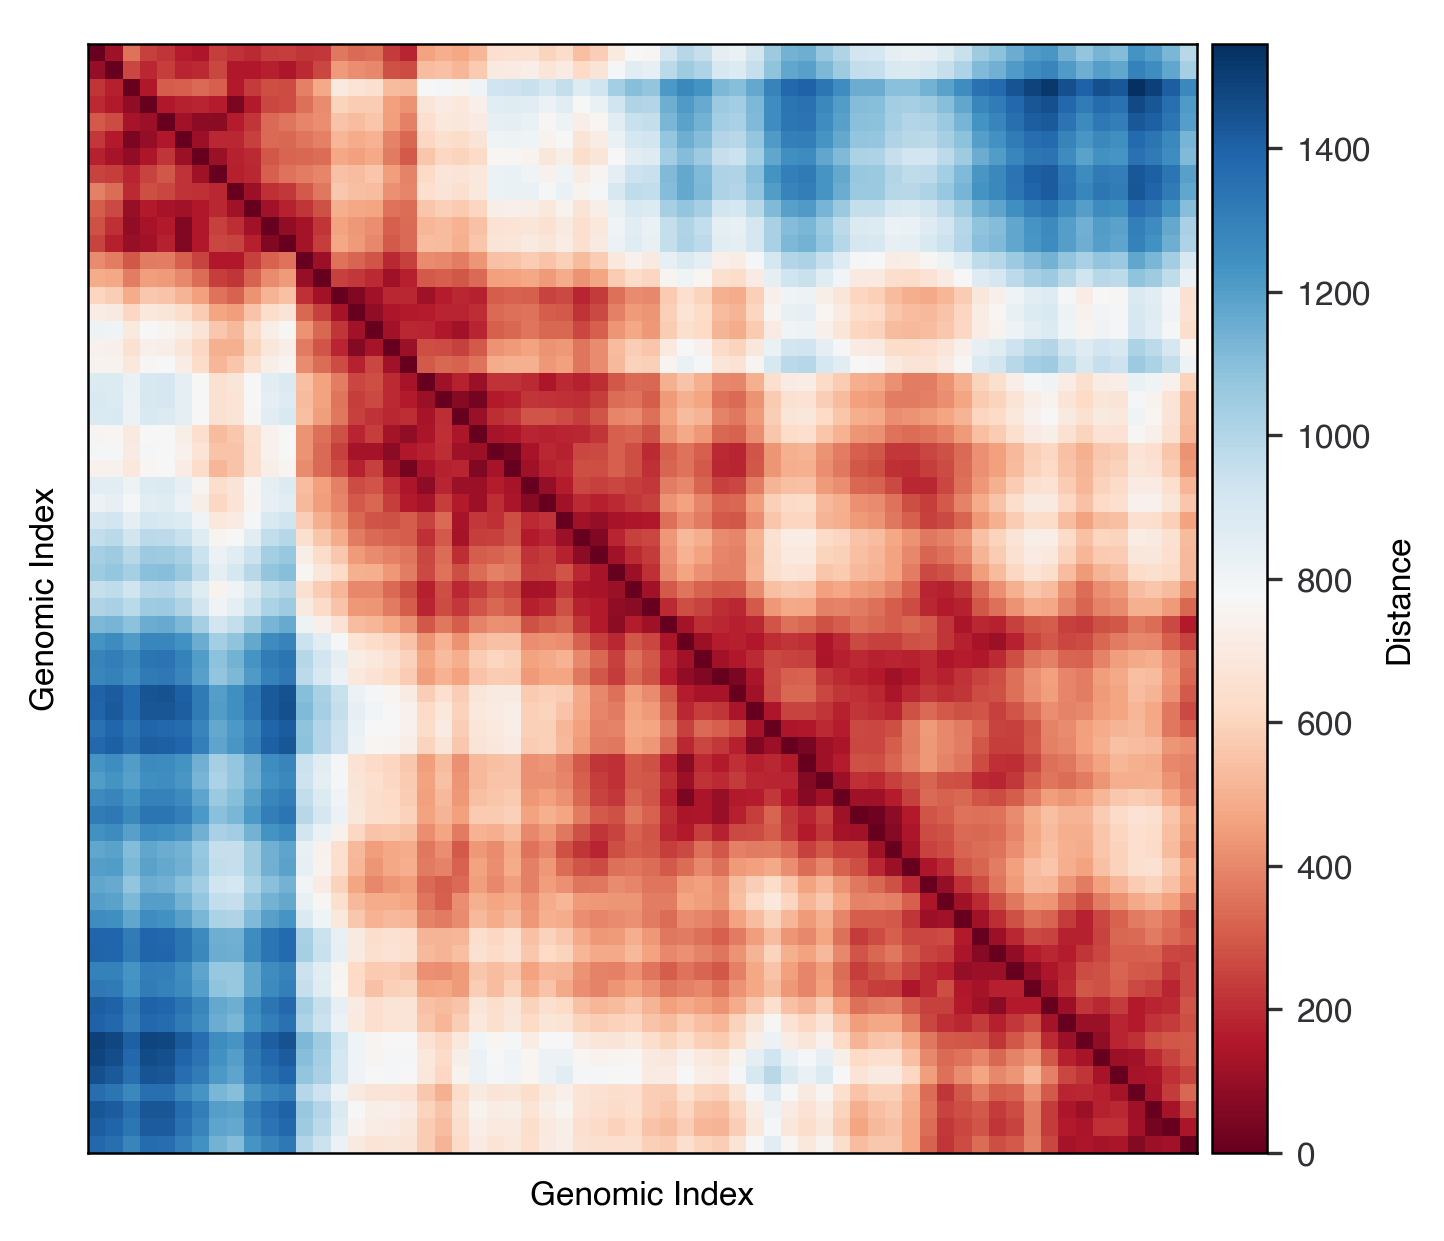

In [11]:
i = torch.where(rmsds==rmsds.min())
tan_coords[2].distances.plot_with(gen_coords[i].distances)

In [12]:
class Compare:

    def __init__(self,gm_hic=gm_hic,imr_hic=imr_hic,region_length=1_280_000,resolution=resolution):
        self.gm = HiCDataset('../data/outside/GM12878_hg19.mcool',resolution)
        self.imr = HiCDataset('../data/outside/IMR90_hg19.mcool',resolution)
        self.region_length = region_length

    def __call__(self,chrom,start,stop=None,*args,**kwargs):

        stop = start + self.region_length if stop is None else stop
        fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(7.08*.45,6.692*.25),layout="constrained")

        hic1 = self.gm.fetch(chrom,start,stop,balance=False)
        n = hic1.prob_map.shape[-1]
        i,j = torch.triu_indices(n,n,1)
        hic1.prob_map[j,i] = self.imr.fetch(chrom,start,stop,balance=False).prob_map[i,j]
        hic1.prob_map/= hic1.prob_map.max()
        
        hic2 = self.gm.fetch(chrom,start,stop,balance=True)
        hic2.prob_map[j,i] = self.imr.fetch(chrom,start,stop,balance=True).prob_map[i,j]

        pm1 = hic1.prob_map
        pm2 = hic2.prob_map
        vmin = min(pm1[(pm1>0) & pm1.isfinite()].min(),pm2[(pm2>0) & pm2.isfinite()].min())

        hic1.plot(*args,vmin=vmin,fig=fig,ax=ax1,**kwargs)
        hic2.plot(*args,vmin=vmin,fig=fig,ax=ax2,**kwargs)

        for ax in [ax1,ax2]:
            ax.text(.995*n-1,.005*n,'GM12878',horizontalalignment='right',verticalalignment='top',
                    color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
            
            ax.text(.005*n,.995*n-1,'IMR-90',horizontalalignment='left',verticalalignment='baseline',
                    color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
            if 'cbar_orientation' in kwargs:
                ax.set_xlabel('')

        fig.suptitle(f'Chromosome {chrom}: {round(start/1e6,3)}-{round(stop/1e6,3)} Mb')

        
        return fig,ax1,ax2
    

compare = Compare()

for chrom,start in [('2',1_000_000),('2',136_500_000),('6',6_000_000),('8',98_750_000),('9',37_500_000),('21',29_250_000)]:
    compare(chrom,start,cbar_orientation='horizontal')

In [13]:
import pandas as pd
rosetta = pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')

In [14]:
def get_region_idx(chrom,start,rosetta=rosetta):
    regions = rosetta[str(chrom).replace('chr','')]
    for i,(_,_,start1) in enumerate(regions):
        if start == start1:
            return i
    return 'NOT FOUND'
    raise Exception('Region not found!')
    

In [15]:
for chrom,start in [('2',1_000_000),('2',136_500_000),('6',6_000_000),('8',98_740_000),('9',37_500_000),('21',29_240_000)]:
    region_idx = get_region_idx(chrom,start)
    print(f'Chromosome {chrom}: {start:,}-{start+1_280_000:,} has region idx {region_idx}')

Chromosome 2: 1,000,000-2,280,000 has region idx 50
Chromosome 2: 136,500,000-137,780,000 has region idx 6284
Chromosome 6: 6,000,000-7,280,000 has region idx 290
Chromosome 8: 98,740,000-100,020,000 has region idx 4600
Chromosome 9: 37,500,000-38,780,000 has region idx 1873
Chromosome 21: 29,240,000-30,520,000 has region idx 705


In [24]:
class CompareWithGenerated:

    def __init__(
        self,
        gm_hic=gm_hic,
        imr_hic=imr_hic,
        region_length=1_280_000,
        resolution=20_000,
        #gen_gm_folder='../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
        gen_gm_folder='../data/samples/origami_64_no_embed_reduction/eval_mode/',
        gen_imr_folder='../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
        rosetta=rosetta,
        cond_scale_w1=1.0,
        rescaled_phi_w1=0.0,
        cond_scale_w5=5.0,
        rescaled_phi_w5=8.0
    ):
        self.gm = HiCDataset('../data/outside/GM12878_hg19.mcool',resolution)
        self.imr = HiCDataset('../data/outside/IMR90_hg19.mcool',resolution)
        self.region_length = region_length

        self.gen_gm_folder = gen_gm_folder
        self.gen_imr_folder = gen_imr_folder
        self.rosetta = rosetta
        self.cond_scale_w1=cond_scale_w1
        self.rescaled_phi_w1=rescaled_phi_w1
        self.cond_scale_w5=cond_scale_w5
        self.rescaled_phi_w5=rescaled_phi_w5

    def __get_region_idx(self,chrom,start):
        for region_idx,(_,_,start_) in enumerate(self.rosetta[chrom]):
            if start == start_:
                return region_idx
        raise Exception('Region not found in rosetta stone!')
    
    def get_gen_coords(self,chrom,start):
        # Multiple coordinates by 100 to convert to nm
        region_idx = self.__get_region_idx(chrom,start)
        #f_w1 = f'chr_{chrom}_{region_idx}_{self.cond_scale_w1}_{self.rescaled_phi_w1}.pt'
        #f_w5 = f'chr_{chrom}_{region_idx}_{self.cond_scale_w5}_{self.rescaled_phi_w5}.pt'
        f_w1 = f'sample_{region_idx}_{self.cond_scale_w1}_{self.rescaled_phi_w1}_120_{chrom}.pt'
        f_w5 = f'sample_{region_idx}_{self.cond_scale_w5}_{self.rescaled_phi_w5}_120_{chrom}.pt'
        
        f1 = self.gen_gm_folder+f_w1
        gm_w1 = Coordinates(f1)
        f1 = self.gen_gm_folder+f_w5
        gm_w5 = Coordinates(f1)

        f1 = self.gen_imr_folder+f_w1
        imr_w1 = Coordinates(f1)
        f1 = self.gen_imr_folder+f_w5
        imr_w5 = Coordinates(f1)

        for coords in [gm_w1,gm_w5,imr_w1,imr_w5]:
            coords._values*= 100 # Convert to nm
            
        return gm_w1,gm_w5,imr_w1,imr_w5
        
    def __call__(self,chrom,start,stop=None,fraction=0.5,cbar_orientation='horizontal',dist_cmap = 'RdBu',
                 dist_vmin=None,dist_vmax=None,*args,**kwargs):

        stop = start + self.region_length if stop is None else stop
        #fig,(count_ax,balance_ax,gen_ax) = plt.subplots(ncols=3, nrows=1, figsize=(7.08*.62,6.692*.28),layout="constrained")
        #fig,(count_ax,balance_ax,gen_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.25),layout="constrained")
        fig,(balance_ax,gen_ax)=plt.subplots(ncols=2, nrows=1, figsize=(7.08*.5*2/3,6.692*.25),layout="constrained")
        
        
        hic2 = self.gm.fetch(chrom,start,stop,balance=True,interp_nans=True)
        n = hic2.prob_map.shape[-1]
        i,j = torch.triu_indices(n,n,1)
        hic2.prob_map[j,i] = self.imr.fetch(chrom,start,stop,balance=True,interp_nans=True).prob_map[i,j]

        #pm1 = hic1.prob_map
        pm2 = hic2.prob_map
        #vmin = min(pm1[(pm1>0) & pm1.isfinite()].min(),pm2[(pm2>0) & pm2.isfinite()].min())
        vmin = pm2[(pm2>0) & pm2.isfinite()].min()
        
        #*_,count_cbar = hic1.plot(*args,vmin=vmin,fig=fig,ax=count_ax,cbar_orientation=cbar_orientation,**kwargs)
        *_,balance_cbar = hic2.plot(*args,vmin=vmin,fig=fig,ax=balance_ax,cbar_orientation=cbar_orientation,vmax=1,**kwargs)

        gen_gm_w1,gen_gm_w5,gen_imr_w1,gen_imr_w5 = self.get_gen_coords(chrom,start)
        #gen_gm = gen_gm_w1.distances.mean
        #gen_gm._values*= fraction
        #gen_gm._values+= gen_gm_w5.distances.mean.values * (1-fraction)
        #gen_imr = gen_imr_w1.distances.mean
        #gen_imr._values*= fraction
        #gen_imr._values+= gen_imr_w5.distances.mean.values * (1-fraction)
        gen_gm = gen_gm_w1.append(gen_gm_w5).distances.median
        gen_imr = gen_imr_w1.append(gen_imr_w5).distances.median

        
        *_,gen_cbar = gen_gm.plot_with(gen_imr,fig=fig,ax=gen_ax,cbar_orientation=cbar_orientation,
                                                     cmap=dist_cmap,vmax=dist_vmax,vmin=dist_vmin)

        for ax in [balance_ax,gen_ax]:#[count_ax,balance_ax,gen_ax]:
            ax.text(.995*n-1,.005*n,'GM12878',horizontalalignment='right',verticalalignment='top',
                    color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
            
            ax.text(.005*n,.995*n-1,'IMR-90',horizontalalignment='left',verticalalignment='baseline',
                    color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
            if 'cbar_orientation' in kwargs:
                ax.set_xlabel('')
        #for ax in [balance_ax,gen_ax]:
        #    ax.set_ylabel('')
        gen_ax.set_ylabel('')
        #balance_ax.set_xlabel('Interaction\nfrequency')
        
        #count_ax.set_title('Normalized counts')
        balance_cbar.set_label('Interaction\nfrequency')
        gen_cbar.set_label('Median\ndistance (nm)')

        #count_cbar.set_label('Normalized counts')
        #for cbar in [balance_cbar,gen_cbar]:
        #    cbar.set_label('')
        
        #gen_cbar.set_label('Distances (nm)')

        fig.suptitle(f'Chromosome {chrom}: {round(start/1e6,3)}-{round(stop/1e6,3)} Mb')

        
        return fig,balance_ax,gen_ax
    

In [25]:
comp_gen = CompareWithGenerated()

In [26]:
regions = {
    '1':[395,1325],
    '2':[3993],
    '5':[1618],
    '6':[290,6358],
    '21':[668],
    '22':[464]
}

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'I', 'M', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'h', 'hyphen', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'six', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 24, 25, 27, 28, 29, 38, 42, 44, 48, 68, 69, 70, 71, 72, 73, 75, 76, 80, 81, 82, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 

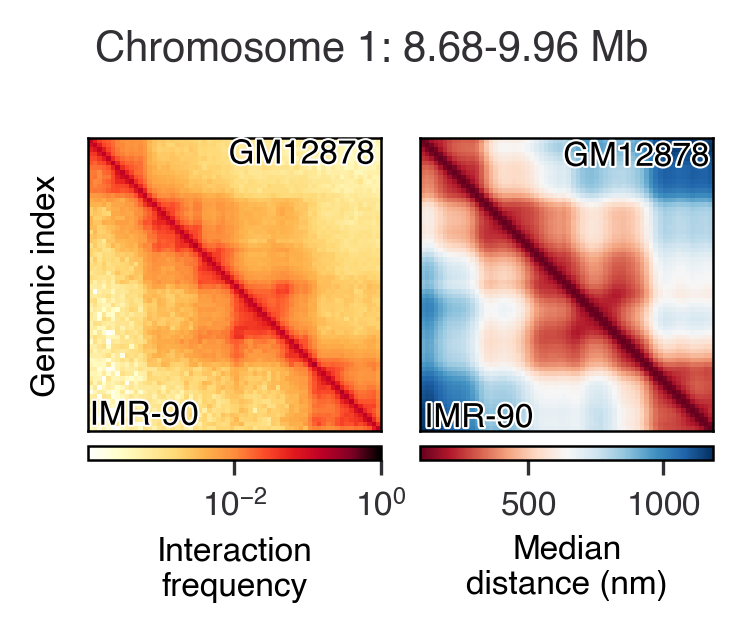

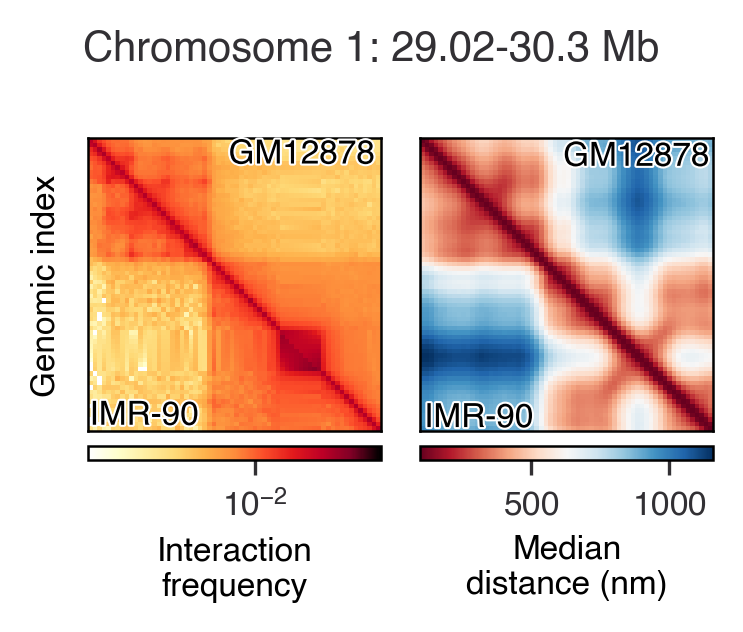

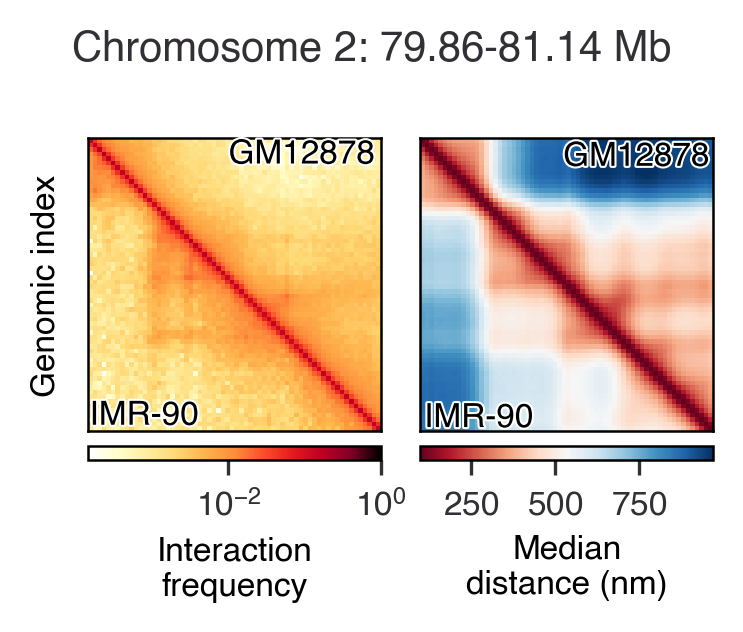

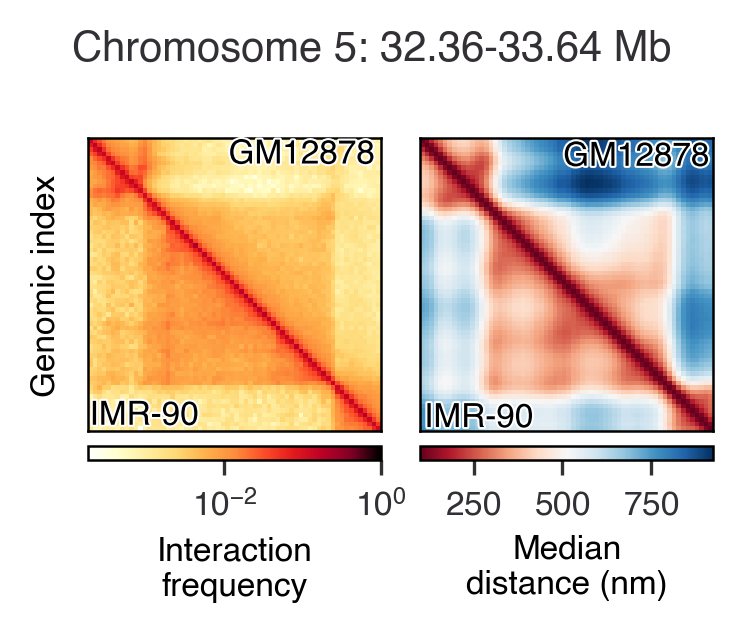

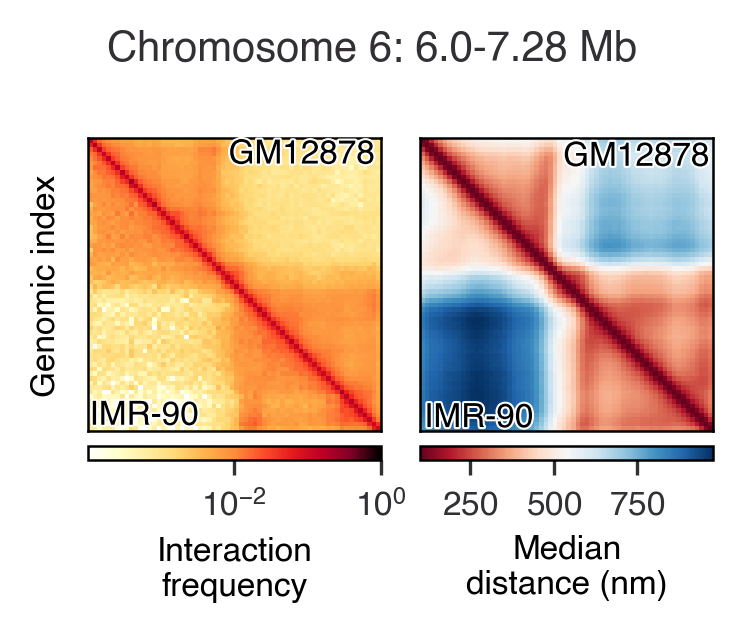

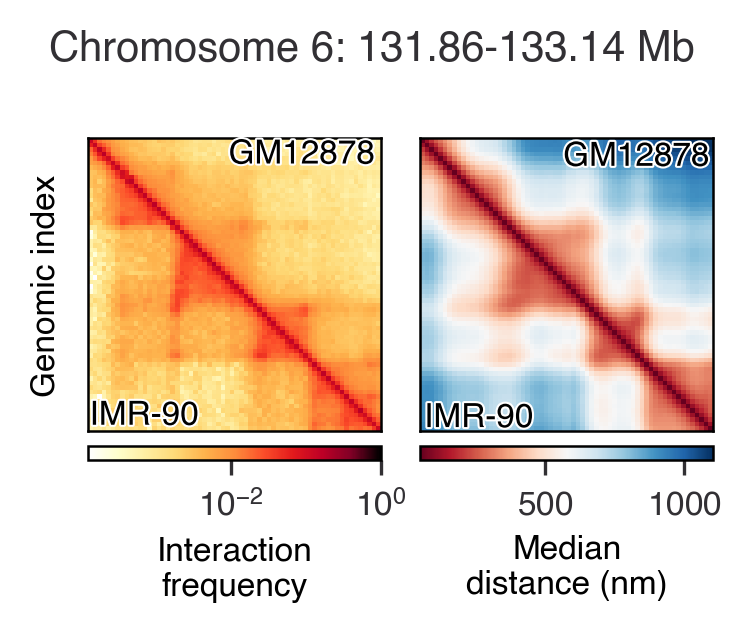

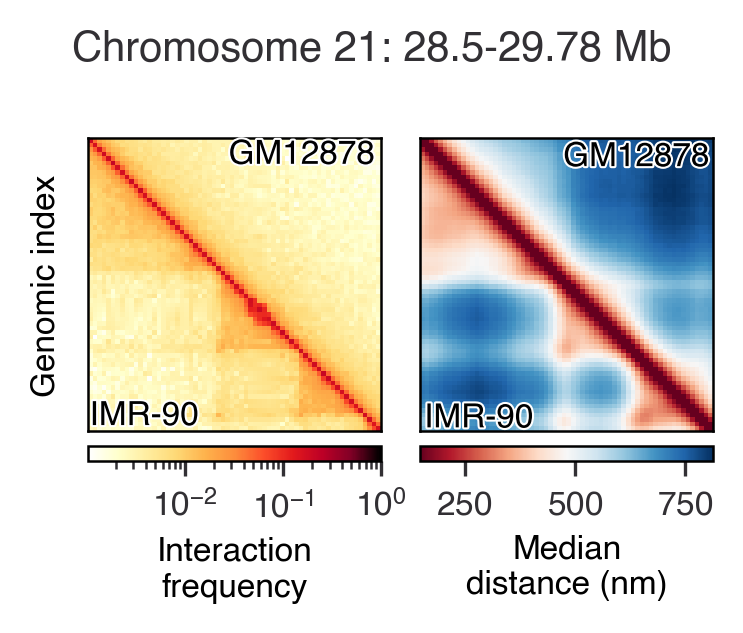

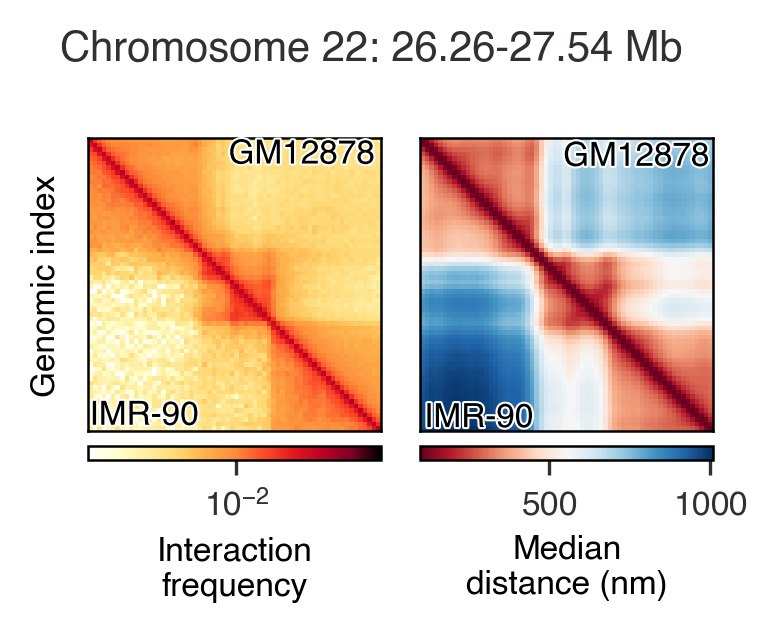

In [27]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for chrom in regions:
    for region_idx in regions[chrom]:
        start = get_genomic_index(chrom,region_idx)

        if (chrom == '6' and region_idx == 6358):
            dist_vmin = 50
        elif (chrom == '21' and region_idx == 668):
            dist_vmin=150
        else:
            dist_vmin=100
        fig,*_ = comp_gen(chrom,start,cbar_orientation='horizontal',dist_cmap='RdBu',dist_vmin=dist_vmin)
        fig.savefig(save_dir + f'chrom_{chrom}_{start}_combined.pdf',bbox_inches='tight',transparent=True)

In [1]:
import torch

In [2]:
a = torch.rand(5,64)
b = torch.rand(5,64)

In [3]:
torch.cov(a,b) 

TypeError: cov() takes 1 positional argument but 2 were given

In [8]:
a,b=config_ds.fetch_specific_coords('19',27_960_000)

In [9]:
len(a),len(b)

(2, 2)

In [10]:
27960000 + 1_280_000

29240000

In [16]:
all_median_distances = torch.load('./HiCCorrelationR2_combined/median_distances.pkl')

refined_vals = {}
for label in ['Dip-C','ChromoGen']:

    # Unfold the maps for easier handling
    data = all_median_distances[label].unfold()
    
    # Get the off-diagonal elements of each median distance map for comparison
    n = data.num_beads
    i,j = torch.triu_indices(n,n,1)
    refined_vals[label] = data.values[:,i,j]

    del data

a = refined_vals['Dip-C']
b = refined_vals['ChromoGen']

PCC = ( (a * b).mean(-1) - a.mean(-1) * b.mean(-1) ) / ( a.std(-1) * b.std(-1) )
del a,b, refined_vals

In [23]:
d = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
gen = Coordinates(d + 'sample_1152_1.0_0.0_120_19.pt').append(
    Coordinates(d + 'sample_1152_5.0_8.0_120_19.pt')
).distances.float()

tan = Coordinates(config_ds.fetch_specific_coords('19',27960000)[1]).distances.float()

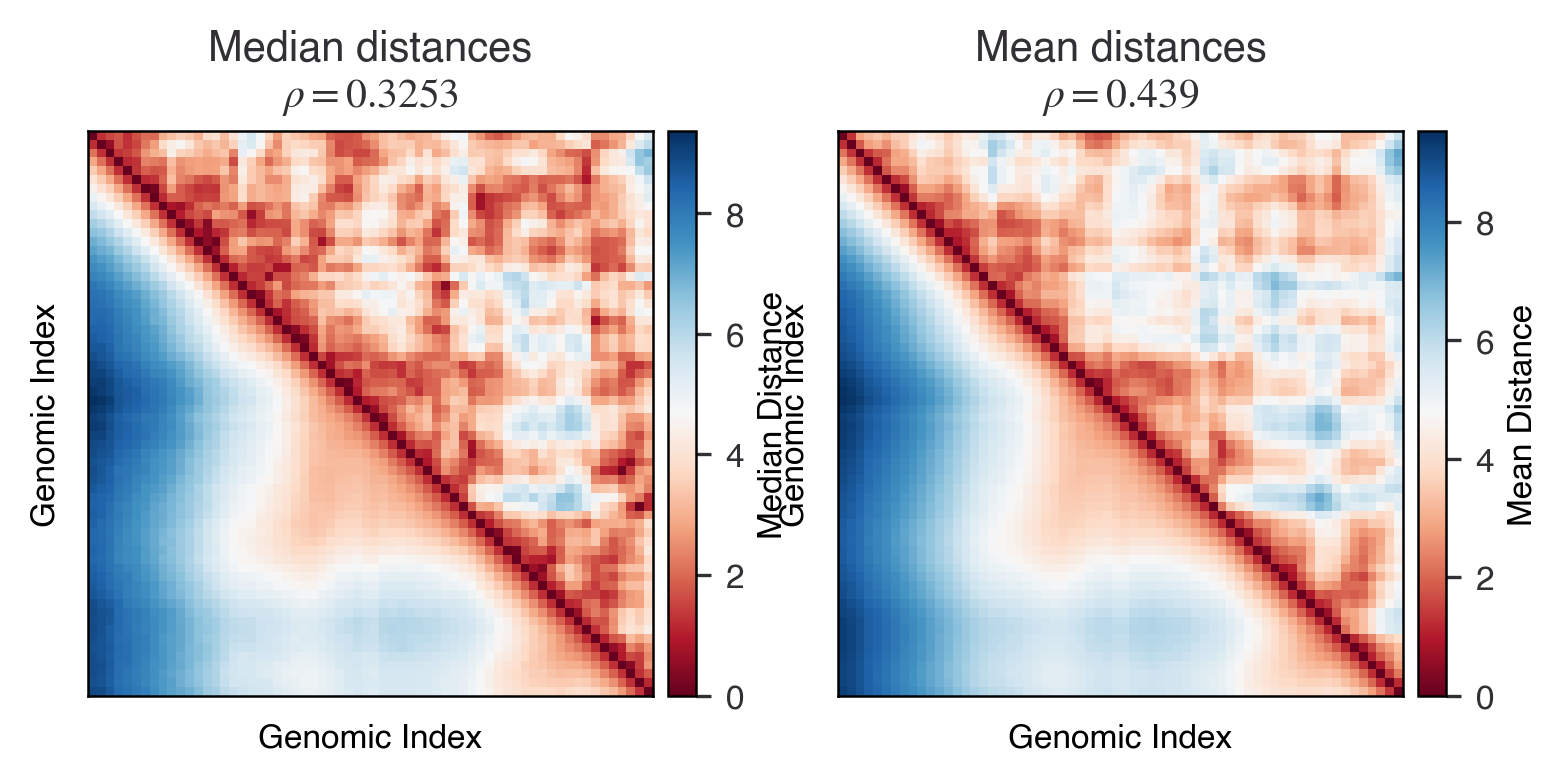

In [27]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(5,2.5),layout='constrained')

n = tan.num_beads
i,j = torch.triu_indices(n,n,1)

for k,(a,b,comp) in enumerate([
    (tan.median,gen.median,'Median'),
    (tan.mean,gen.mean,'Mean')
]):
    ax = axes[k]
    a.plot_with(b,fig=fig,ax=ax)
    rho = round(
        torch.corrcoef(
            torch.stack(
                [
                    a.values[0,i,j],
                    b.values[0,i,j]
                ],
                dim=0
            )
        )[0,1].tolist(),
        4
    )
    ax.set_title(comp+' distances\n$\\rho='+f'{rho}'+'$')

In [3]:
a = torch.load('./HiCCorrelationR2_combined/median_distances.pkl')

In [5]:
x = a['Number Dip-C conformations']
N = len(x)
fraction_available = []
for i in range(x.max()+2):
    fraction_available.append(
        (x >= i).sum() / N 
    )

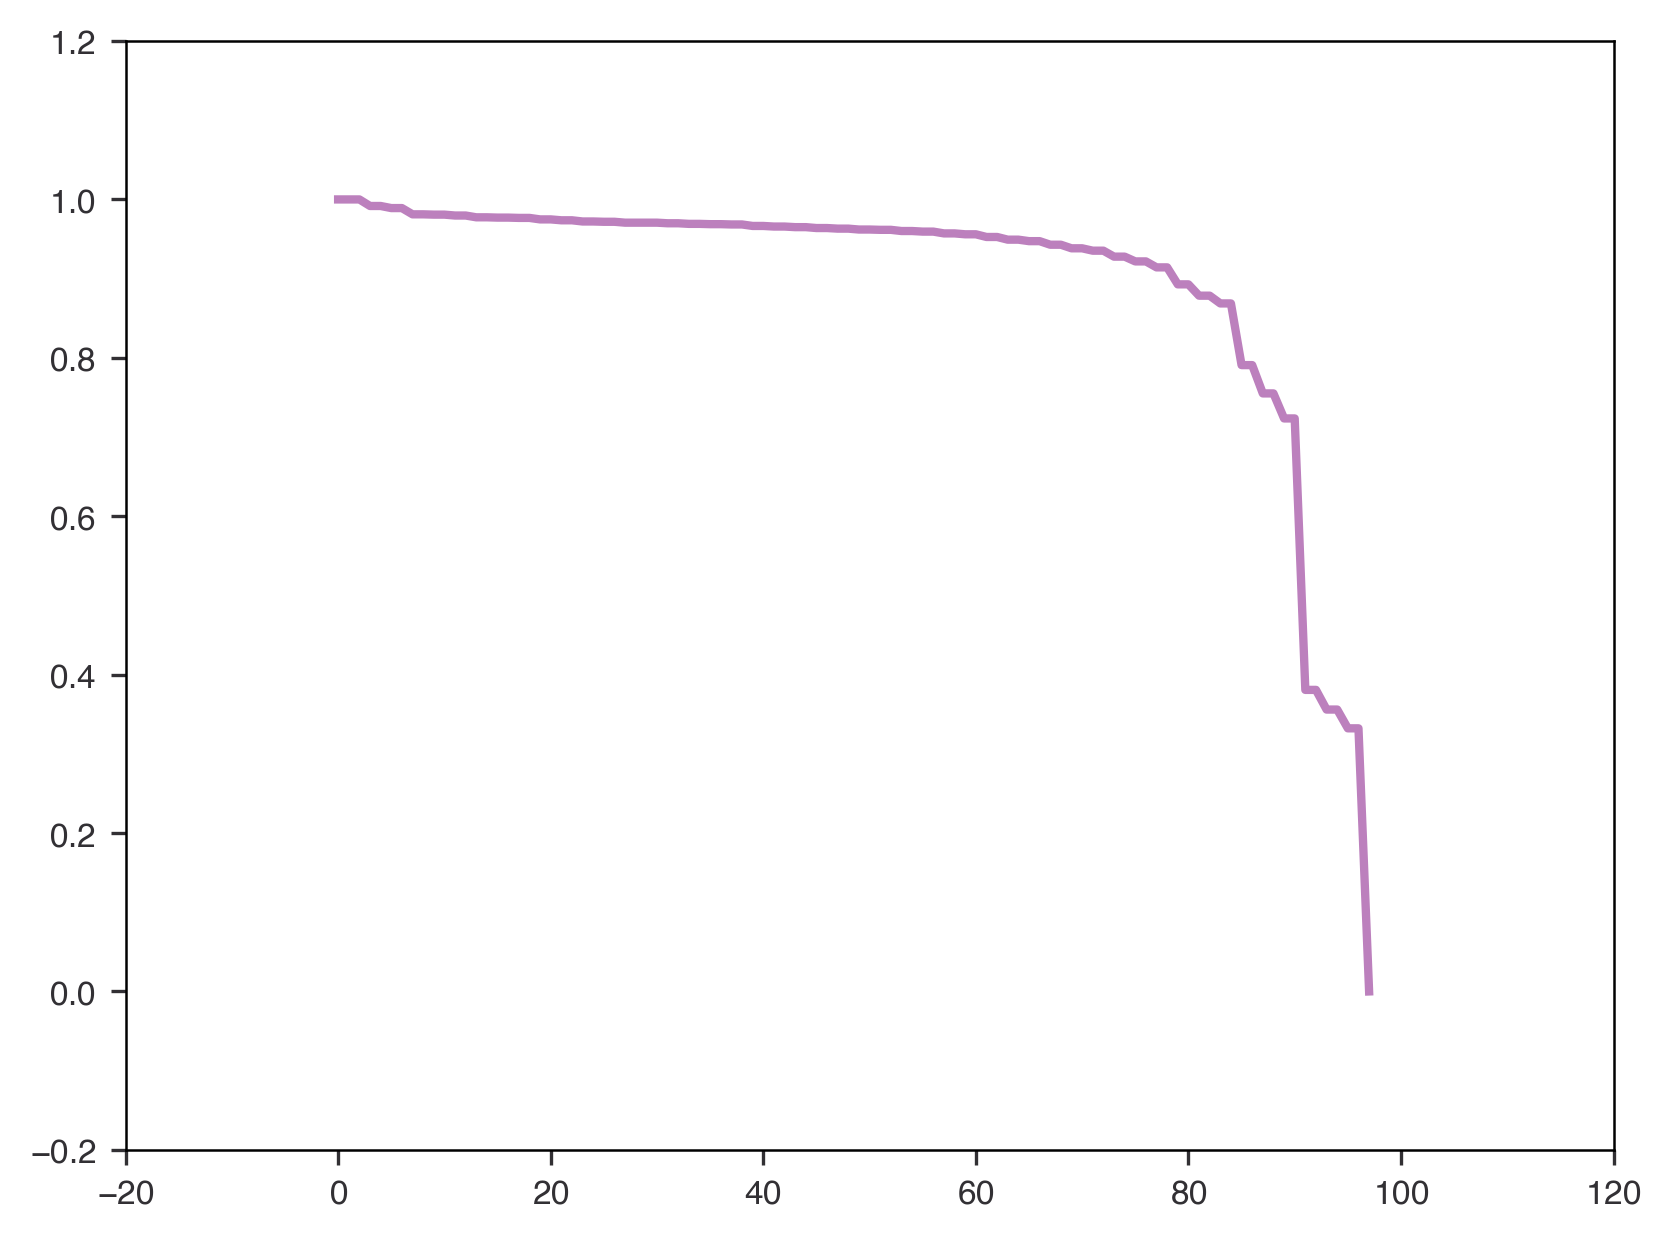

In [6]:
plt.plot(fraction_available)

In [12]:
fraction_available[80]

tensor(0.8928)